<a href="https://www.kaggle.com/code/fareshamdy/mask-detection-model-ipynb?scriptVersionId=195721193" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/examples-for-test/360_F_222851624_jfoMGbJxwRi5AWGdPgXKSABMnzCQo9RN.jpg
/kaggle/input/examples-for-test/African20businesswoman20with20face20mask20in20office.jpeg
/kaggle/input/face-mask-detection/Dataset/without_mask/2664.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2539.png
/kaggle/input/face-mask-detection/Dataset/without_mask/1231.png
/kaggle/input/face-mask-detection/Dataset/without_mask/1017.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2437.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2015.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2300.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2673.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2823.png
/kaggle/input/face-mask-detection/Dataset/without_mask/1522.png
/kaggle/input/face-mask-detection/Dataset/without_mask/2064.png
/kaggle/input/face-mask-detection/Dataset/without_mask/641.png
/kaggle/input/face-mask-detection/Dataset/without_mask/108

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from glob import glob

In [3]:
dataset_path = '/kaggle/input/face-mask-detection/Dataset'
mask_weared_incorrect = glob('/kaggle/input/face-mask-detection/Dataset/mask_weared_incorrect/*.png')
with_mask = glob('/kaggle/input/face-mask-detection/Dataset/with_mask/*.png')
without_mask = glob('/kaggle/input/face-mask-detection/Dataset/without_mask/*.png')

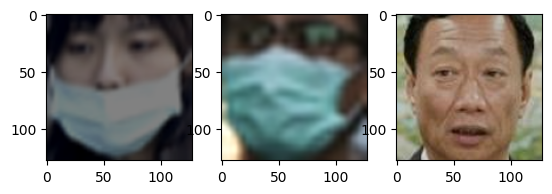

In [4]:
fig, ax = plt.subplots(1,3)
img1 = plt.imread(mask_weared_incorrect[0])
ax[0].imshow(img1)
img2 = plt.imread(with_mask[0])
ax[1].imshow(img2)
img3 = plt.imread(without_mask[0])
ax[2].imshow(img3)

plt.show()

```
def process_images(images):
    processed_images = []
    for image in mask_weared_incorrect:
        img = cv2.imread(image)
        if img is None:
            print(f"Error reading image: {image}")
            continue
        img = cv2.resize(img, (128,128))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.array(img)
        processed_images.append(img)
    return processed_images

mask_incorrect = process_images(mask_weared_incorrect)
mask_on = process_images(with_mask)
mask_off = process_images(without_mask)
    


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale = 1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2
)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/face-mask-detection/Dataset',
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = datagen.flow_from_directory(
    '/kaggle/input/face-mask-detection/Dataset',
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.


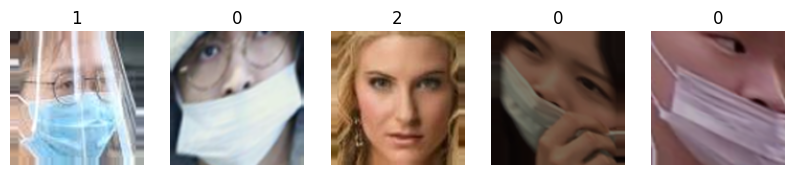

In [6]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5, i+1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))
    plt.axis('off')
    
plt.show()

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from keras import layers
import keras

In [8]:
base_model = MobileNetV2(input_shape = (128,128,3), include_top = False, weights='imagenet')

base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Adding a Global Average Pooling layer
x = layers.Dense(128, activation='relu')(x)  # Adding a Dense layer
x = layers.Dense(3, activation='softmax')(x)

model = Model(inputs= base_model.input, outputs = x)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics= ['accuracy'])

model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
history = model.fit(
train_generator,
epochs = 10,
validation_data= validation_generator)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725725417.081919      80 service.cc:145] XLA service 0x797ad8002f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725725417.081976      80 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/225 ━━━━━━━━━━━━━━━━━━━━ 40:46 11s/step - accuracy: 0.2500 - loss: 2.1599

I0000 00:00:1725725421.219770      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 85s 331ms/step - accuracy: 0.8715 - loss: 0.3648 - val_accuracy: 0.9593 - val_loss: 0.1214
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 196ms/step - accuracy: 0.9661 - loss: 0.0963 - val_accuracy: 0.9738 - val_loss: 0.0832
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 193ms/step - accuracy: 0.9740 - loss: 0.0727 - val_accuracy: 0.9565 - val_loss: 0.1341
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 190ms/step - accuracy: 0.9742 - loss: 0.0711 - val_accuracy: 0.9660 - val_loss: 0.0921
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 194ms/step - accuracy: 0.9820 - loss: 0.0505 - val_accuracy: 0.9660 - val_loss: 0.0959
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.9821 - loss: 0.0473 - val_accuracy: 0.9783 - val_loss: 0.0703
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 192ms/step - accuracy: 0.9844 - loss: 0.0458 - val_accuracy: 0.9777 - val_loss: 0.0702
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 190ms/step - accuracy: 0.9853 - loss: 0.0411 - val

In [10]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy*100:.2f}%')


57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.9783 - loss: 0.0603
Validation Accuracy: 97.49%


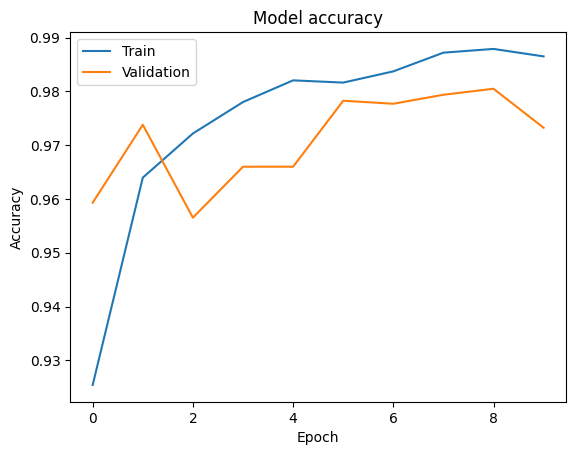

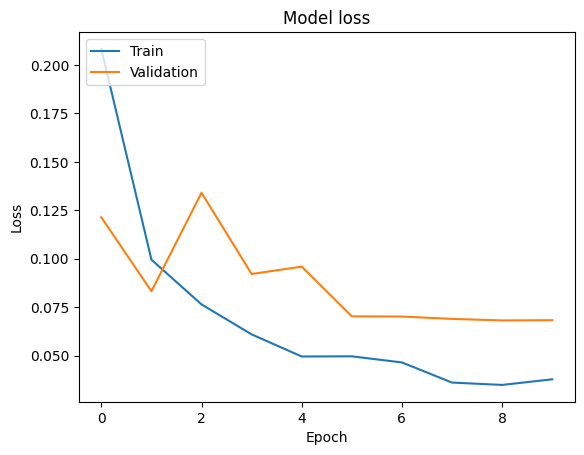

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [12]:
model.save('/kaggle/working/mask_detection_model.h5')



In [13]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(128, 128))
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    # Add a batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image
    img_array /= 255.0
    return img_array

# Paths to the test images
img_paths = [
    '/kaggle/input/examples-for-test/360_F_222851624_jfoMGbJxwRi5AWGdPgXKSABMnzCQo9RN.jpg',
    '/kaggle/input/examples-for-test/African20businesswoman20with20face20mask20in20office.jpeg'
]

# Preprocess images
preprocessed_images = [preprocess_image(img_path) for img_path in img_paths]


In [14]:
# Make predictions
predictions = [model.predict(img) for img in preprocessed_images]

# Decode predictions
class_labels = ['mask_weared_incorrect', 'with_mask', 'without_mask']
predicted_classes = [class_labels[np.argmax(pred)] for pred in predictions]

for img_path, pred_class in zip(img_paths, predicted_classes):
    print(f'Image: {img_path} - Predicted Class: {pred_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: /kaggle/input/examples-for-test/360_F_222851624_jfoMGbJxwRi5AWGdPgXKSABMnzCQo9RN.jpg - Predicted Class: without_mask
Image: /kaggle/input/examples-for-test/African20businesswoman20with20face20mask20in20office.jpeg - Predicted Class: with_mask


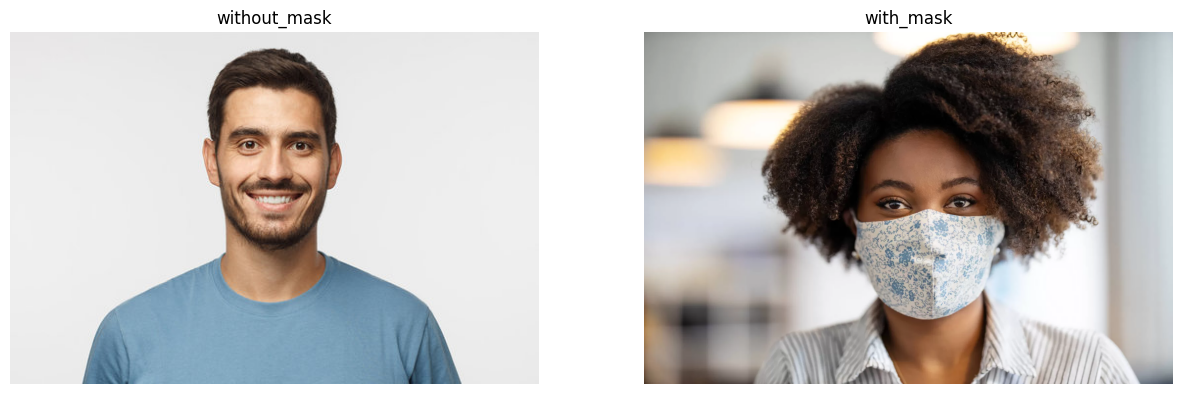

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images_with_predictions(img_paths, predictions):
    plt.figure(figsize=(15, 5))
    
    for i, (img_path, pred_class) in enumerate(zip(img_paths, predictions)):
        plt.subplot(1, len(img_paths), i+1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(pred_class)
        plt.axis('off')
    
    plt.show()

# Display images with predictions
display_images_with_predictions(img_paths, predicted_classes)
